# 01: Sampling

This notebook locates and samples plots, exporting an HDF5 dataset with arrays of LiDAR metrics and NAIP reflectance values for each plot footprint.

In [1]:
import ee

from naip_cnn import sampling
from naip_cnn.acquisitions import (
    MAL2010,
    MAL2016_CanyonCreek,
    MAL2017_Crow,
    MAL2017_JohnDay,
)
from naip_cnn.data import NAIPDatasetWrapper

# If you are not authenticated locally, run `ee.Authenticate()` first.
ee.Initialize()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.19) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Load Data

Our training data will be a set of points with 1) LiDAR attributes for prediction and 2) corresponding NAIP reflectance values. Both will ultimately be stored as co-located 2D arrays of pixel values at footprint locations. 

The first step will be to create a `NAIPDatasetWrapper` that will allow us to access LiDAR and NAIP data, as well as store relevant metadata such as the spatial resolution and sample footprint size in meters.

In [2]:
dataset = NAIPDatasetWrapper(
    acquisitions=[MAL2010],
    footprint=(30, 30),
    naip_res=1.0,
    lidar_res=30.0,
)

Based on the acquisition and resolution parameters defined above, we can load coincident `ee.Image` mosaics of LiDAR and NAIP data.

In [3]:
lidar = dataset.load_lidar()
naip = dataset.load_naip()

/usr/local/lib/python3.8/dist-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for USFS/GTAC/LCMS/v2022-8! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_LCMS_v2022-8

  warnings.warn(warning, category=DeprecationWarning)


## Generate Sample Footprints

We'll extract data across a collection of footprints. To begin, we'll distribute points across the LiDAR image with a minimum spacing.

In [4]:
samples = lidar.sample(
    scale=dataset.spacing,
    projection=dataset.acquisitions[0].proj,
    factor=0.6,
    dropNulls=True,
    geometries=True,
)

We can check `samples.size` to figure out how many non-masked pixels were sampled at the given spacing.

In [5]:
samples.size().getInfo()

592940

Next, we'll convert our collection of sample points to square footprints with a given size.

In [8]:
footprints = samples.map(
    lambda p: sampling.point_to_footprint(
        p, dims=dataset.footprint, proj=dataset.acquisition.proj
    )
)

## Extract Pixel Values

With our footprints defined, we can extract arrays of pixel values from the LiDAR and NAIP images.

In [9]:
def extract_lidar(footprint: ee.Feature):
    return sampling.extract_values_at_footprint(
        footprint, img=lidar, proj=dataset.acquisition.proj, scale=dataset.lidar_res
    )


def extract_naip(footprint: ee.Feature):
    return sampling.extract_values_at_footprint(
        footprint, img=naip, proj=dataset.acquisition.proj, scale=dataset.naip_res
    )


footprints = footprints.map(extract_lidar, opt_dropNulls=True).map(
    extract_naip, opt_dropNulls=True
)

## Export to Drive

Extracting large numbers of pixel values across footprints is memory- and time-intensive, so we'll need to export the data to Drive rather than directly accessing it client-side. This process can take a while, and progress can be monitored in the [task manager](https://code.earthengine.google.com/tasks).

***Note**: Make sure you're authenticated with the correct Earth Engine account, as this will determine the Drive to which data is exported.*

In [10]:
task = ee.batch.Export.table.toDrive(
    collection=footprints,
    description=dataset.name,
)

task.start()

## Convert CSV To HDF5

*Once the export task is complete*, you'll need to download the resulting CSV file to local storage. 

The CSV format exported by Earth Engine is not optimized for training, so we'll need to convert it to an HDF5 file. In the process, we'll reshape the pixel arrays, which are currently stored as comma-separated strings, into 2D arrays.

In [20]:
from dask.distributed import Client
import dask.dataframe as dd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

We'll use Dask to parallelize the loading and processing steps. Creating a local Dask client will allow us to monitor progress in the Dask dashboard.

In [21]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 58.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40019,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 58.86 GiB
Comm: tcp://127.0.0.1:34259,Total threads: 2
Dashboard: http://127.0.0.1:46517/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:37923,


Load the CSV file as a deferred Dask dataframe. You'll see that it includes columns for each of the NAIP bands, LiDAR attributes, and a few other metadata columns.

In [24]:
df = dd.read_csv("../" + dataset.csv_path.as_posix())
df

,system:index,B,G,N,R,cover,height,rh100,rh25,rh50,rh95,width,.geo
npartitions=175,,,,,,,,,,,,,
,int64,object,object,object,object,object,int64,object,object,object,object,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


Next, we'll parse the 1D strings into 2D arrays. We'll stack the NAIP arrays into a single `image` column, while each of the LiDAR labels will be kept in its own column, allowing us to easily train on a single label.

In [25]:
df["image"] = df.apply(
    sampling.parse_pixel_array,
    shape=dataset.naip_shape,
    col=("R", "G", "B", "N"),
    axis=1,
    meta=pd.Series(dtype=np.uint8),
)

for label in ("cover", "rh25", "rh50", "rh95", "rh100"):
    df[label] = df.apply(
        sampling.parse_pixel_array,
        shape=dataset.lidar_shape,
        col=label,
        axis=1,
        meta=pd.Series(dtype=np.float32),
    )

Now, we can drop the unused columns.

In [26]:
df = df.drop(columns=["R", "G", "B", "N", ".geo", "height", "width", "system:index"])

Next, we'll load the entire dataframe into memory so that we can shuffle it, split it, and save it out to HDFs.

In [27]:
df = df.compute().sample(frac=1, random_state=42)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Split the data into training, validation, and test sets. We do this now to avoid having to load the entire dataset into memory to properly shuffle during the training process.

In [28]:
train, holdout = train_test_split(df, train_size=0.8, random_state=42)
val, test = train_test_split(holdout, train_size=0.5, random_state=42)

In [29]:
for split, split_df in ({"train": train, "val": val, "test": test}).items():
    dst_path = (
        "../"
        + dataset.csv_path.with_name(
            dataset.csv_path.stem + f"_{split}" + ".h5"
        ).as_posix()
    )
    with h5py.File(dst_path, "w") as f:
        for var in ("image", "cover", "rh25", "rh50", "rh95", "rh100"):
            f.create_dataset(
                var, data=np.stack(split_df[var].values), compression="gzip"
            )

Just to get an idea of the data we'll be training with, we can plot a few footprints.

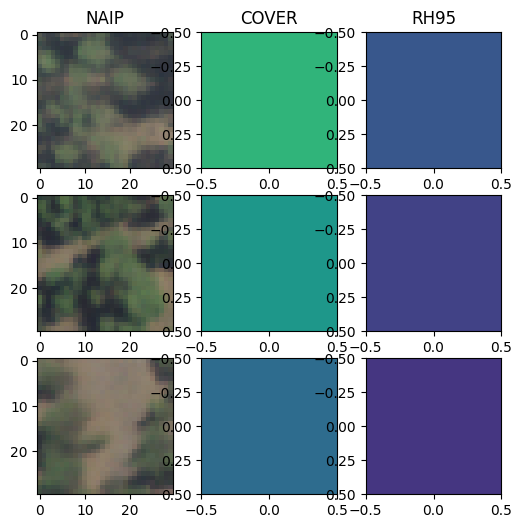

In [23]:
n = 3
check_footprints = train.sample(n=n, random_state=99)

fig, ax = plt.subplots(n, 3, figsize=(6, n * 2))
for i in range(n):
    ax[i, 0].imshow(check_footprints["image"].values[i][:, :, :3])
    ax[i, 1].imshow(check_footprints["cover"].values[i], vmin=0, vmax=100)
    ax[i, 2].imshow(check_footprints["rh95"].values[i], vmin=0, vmax=100)

ax[0, 0].set_title("NAIP")
ax[0, 1].set_title("COVER")
ax[0, 2].set_title("RH95");